# xTを含んだ転写

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [4]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [5]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: glasses.png
 8: idPhoto.png
 9: mio_happy.png
10: mio_shock.png
11: mio_silence.png
12: mio_u.png
13: nanko_default.png
14: ookawa_angry.png
15: ookawa_angry2.png
16: ookawa_default.png
17: ookawa_high.png
18: ookawa_regret.png
19: ookawa_smile.png
20: ookawa_surprised.png
21: pharmacist.png
22: saki.png
23: saki_glasses.png
24: sandy.png
25: takebe_default.png
26: test01.png
27: test01_02.png
28: test01_03.png
29: test01_04.png
30: test02.png
31: test02_02.png
32: test02_03.png
33: woman_default.png
34: yotaka_angry.png
35: yotaka_angry2.png
36: yotaka_bald.png
37: yotaka_bushy.png
38: yotaka_default.png
39: yotaka_gj.png
40: yotaka_smile.png
41: yotaka_smile2.png


In [121]:
data = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
# 転写元指定(from, to)
ind_src = [38,40]
batch_src = []
name_src = []
for i in ind_src:
    batch_src.append(data[i]['img'])
    name_src.append(os.path.splitext(str(data.paths[i]))[0])
batch_src = torch.stack(batch_src)

# 転写先指定
ind_tgt = {13,33}
batch_tgt = []
name_tgt = []
for i in ind_tgt:
    batch_tgt.append(data[i]['img'])
    name_tgt.append(os.path.splitext(str(data.paths[i]))[0])
batch_tgt = torch.stack(batch_tgt)

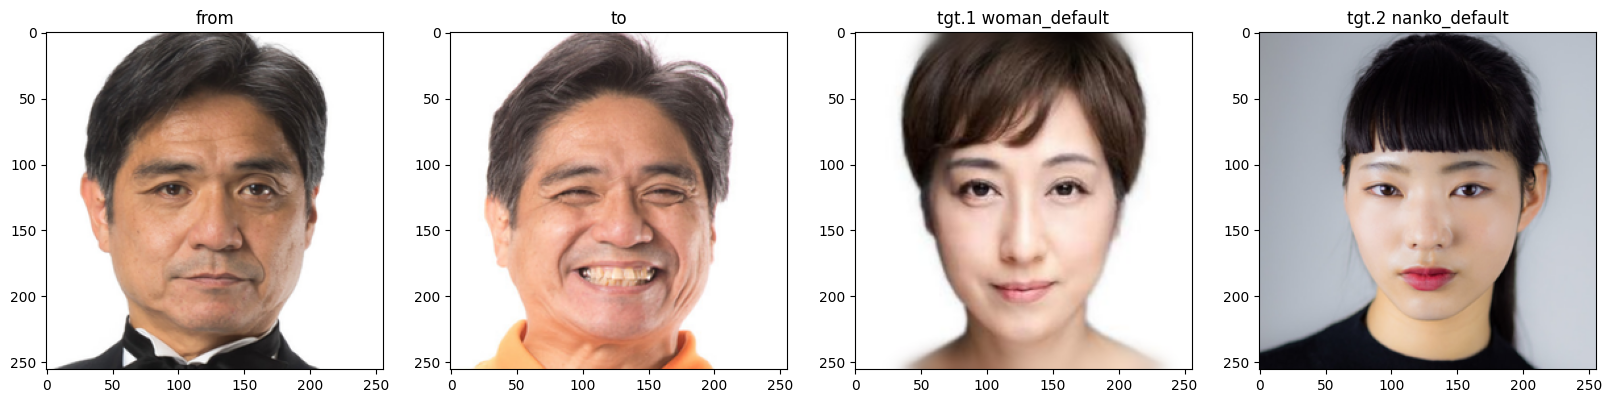

In [122]:
import matplotlib.pyplot as plt

num_tgt = len(batch_tgt)
fig, ax = plt.subplots(1, 2+num_tgt, figsize=(5*(2+num_tgt), 5))
ax[0].imshow(batch_src[0].permute([1, 2, 0]) / 2 + 0.5)
ax[0].set_title(f"from")
ax[1].imshow(batch_src[1].permute([1, 2, 0]) / 2 + 0.5)
ax[1].set_title(f"to")

for i in range(num_tgt):
    ax[i+2].imshow(batch_tgt[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+2].set_title(f"tgt.{i+1} {name_tgt[i]}")

plt.show()

In [123]:
cond_src = []
xT_src = []
for i in range(2):
    cond_src.append(model.encode(batch_src[i][None].to(device))[0])
    xT_src.append(model.encode_stochastic(batch_src[i][None].to(device), cond_src[i][None], T=250)[0])
cond_src = torch.stack(cond_src)
xT_src = torch.stack(xT_src)

cond_tgt = []
xT_tgt = []
for i in range(num_tgt):
    cond_tgt.append(model.encode(batch_tgt[i][None].to(device))[0])
    xT_tgt.append(model.encode_stochastic(batch_tgt[i][None].to(device), cond_tgt[i][None], T=250)[0])
cond_tgt = torch.stack(cond_tgt)
xT_tgt = torch.stack(xT_tgt)

In [124]:
alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)

**転写元のxTをSlerp(球面線形補間)する**  

$$Slerp(from,to;\alpha)=\frac{\sin(1-\alpha)\theta}{\sin\theta}from+\frac{\sin\alpha\theta}{\sin\theta}to$$

In [125]:
def cos(a, b):
    # 平坦化
    a = a.view(-1)
    b = b.view(-1)
    # ノルムが1になるように正規化
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

# fromとtoのなす角Θを求める
theta_src = torch.arccos(cos(xT_src[0], xT_src[1]))
x_shape = xT_src[0].shape
intp_src = (torch.sin((1 - alpha[:, None]) * theta_src) * xT_src[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta_src) * xT_src[1].flatten(0, 2)[None]) / torch.sin(theta_src)
intp_src = intp_x_src.view(-1, *x_shape)

In [130]:
alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)

変化ベクトルを足す

Lerp版

In [166]:
conds = torch.tensor([], device=device)
xTs = torch.tensor([], device=device)
cond_change = cond_src[1] - cond_src[0]
xT_change = xT_src[1] - xT_src[0]
for i in range(num_tgt):
    cond_tmp = torch.tensor([], device=device)
    xT_tmp = torch.tensor([], device=device)
    xT_tgt_norm = torch.linalg.norm(xT_tgt[i])
    for j,alp in enumerate(alpha):
        # Zsemで変化ベクトルを足す
        cond = cond_tgt[i] + alp * cond_change
        # xTで変化ベクトルを足す
        xT = xT_tgt[i] + alp * xT_change
        # xT_tgtのノルムに合わせる
        xT_norm = torch.linalg.norm(xT)
        xT = xT / xT_norm * xT_tgt_norm
        
        cond_tmp = torch.cat([cond_tmp, cond[None]], dim=0)
        xT_tmp = torch.cat([xT_tmp, xT[None]], dim=0)
    conds = torch.cat([conds, cond_tmp[None]], dim=0)
    xTs = torch.cat([xTs, xT_tmp[None]], dim=0)

Slerp版

In [169]:
conds = torch.tensor([], device=device)
xTs = torch.tensor([], device=device)
cond_change = cond_src[1] - cond_src[0]
for i in range(num_tgt):
    cond_tmp = torch.tensor([], device=device)
    xT_tmp = torch.tensor([], device=device)
    xT_tgt_norm = torch.linalg.norm(xT_tgt[i])
    xT_change = 0
    for j,alp in enumerate(alpha):
        # Zsemで変化ベクトルを足す
        cond = cond_tgt[i] + alp * cond_change
        if j > 0:
            xT = xT_tmp[j-1]
        # xTで変化ベクトルを足す
        xT = xT_tgt[i] + alp * xT_change
        # xT_tgtのノルムに合わせる
        xT_norm = torch.linalg.norm(xT)
        xT = xT / xT_norm * xT_tgt_norm
        if j+1 < len(alpha):
            # xTの変化ベクトルの更新
            xT_change = intp_src[j+1] - intp_src[j]

        cond_tmp = torch.cat([cond_tmp, cond[None]], dim=0)
        xT_tmp = torch.cat([xT_tmp, xT[None]], dim=0)
    conds = torch.cat([conds, cond_tmp[None]], dim=0)
    xTs = torch.cat([xTs, xT_tmp[None]], dim=0)

結果を出力

In [170]:
preds = torch.tensor([], device=device)
for i in range(num_tgt):
    pred_tmp = torch.tensor([], device=device)
    for j in range(len(alpha)):
        pred = model.render(xTs[i,j][None], conds[i,j][None], T=20)
        pred_tmp = torch.cat([pred_tmp, pred], dim=0)
    preds = torch.cat([preds, pred_tmp[None]], dim=0)

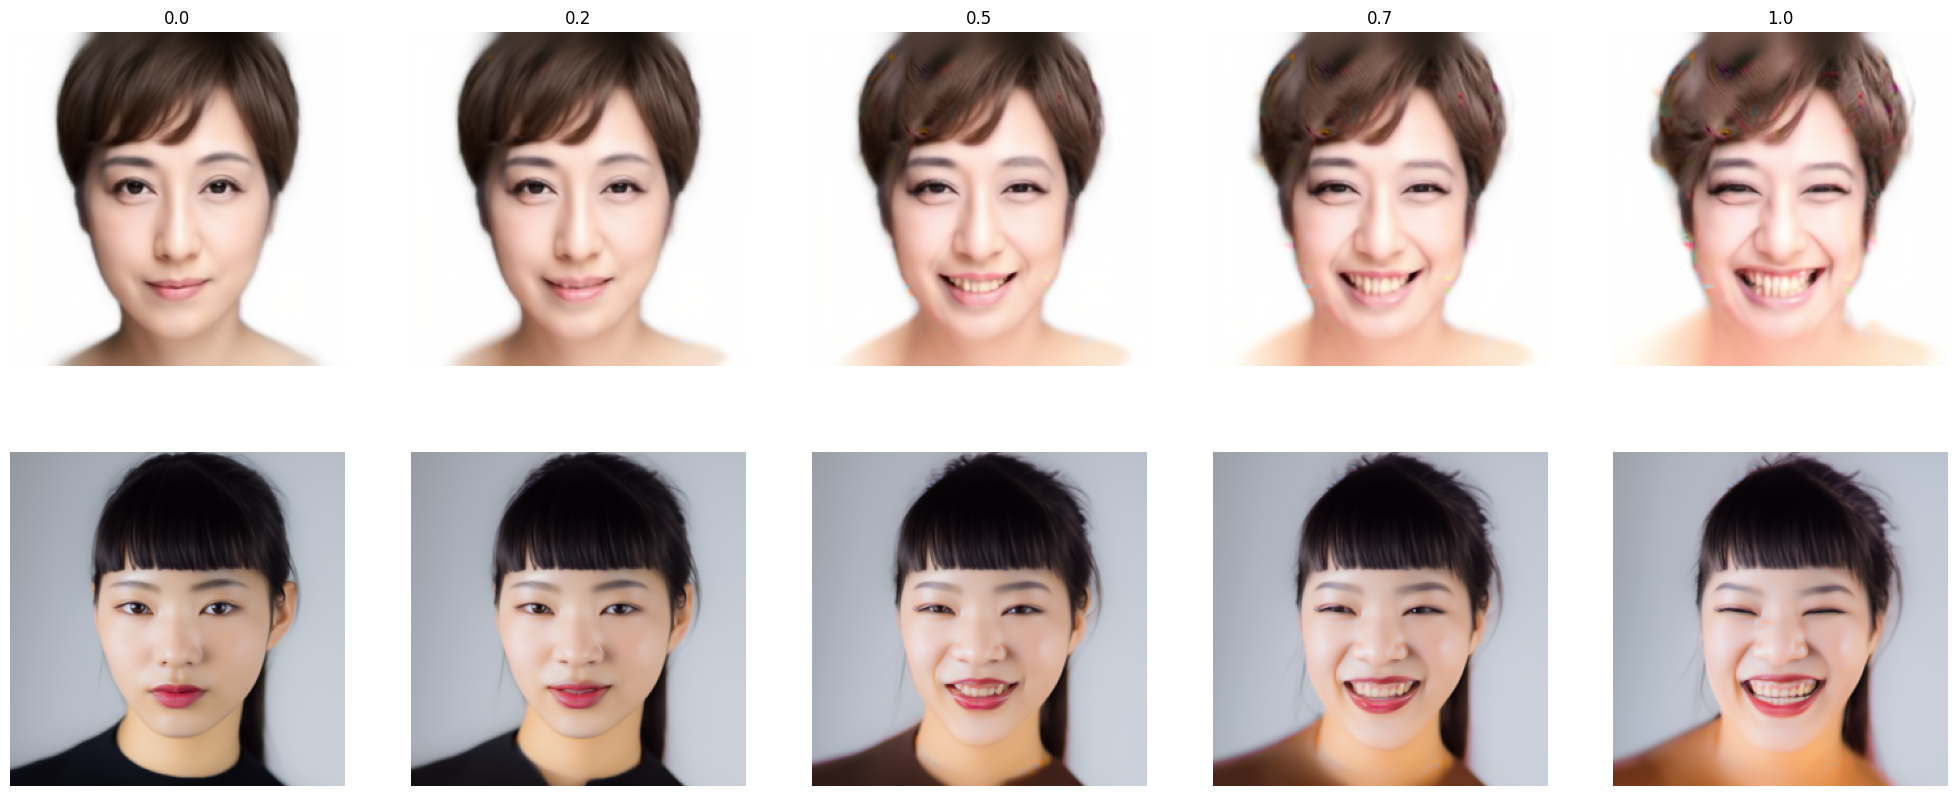

In [171]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_tgt, num_show, figsize=(5*num_show, 5*num_tgt))
for i,pred in enumerate(preds):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [151]:
from PIL import Image

preds_pil = []
for pred in preds:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pil.append(pred_pil)

In [152]:
dst_dir = "test/transfer_xT/"
for i,pred_pil in enumerate(preds_pil):
    dst_dir2 = f"{dst_dir}{name_src[0]}2{name_src[1]}-trans-{name_tgt[i]}/"
    if not os.path.exists(dst_dir2): os.makedirs(dst_dir2)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = dst_dir2 + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=4000//(len(alpha)),
        loop=0,
    )

In [155]:
from torchvision.utils import save_image

dst_dir = "test/transfer_xT/"
select_ind = {0,5,10}
for i,pred in enumerate(preds):
    dst_dir2 = f"{dst_dir}{name_src[0]}2{name_src[1]}-trans-{name_tgt[i]}/"
    if not os.path.exists(dst_dir2): os.makedirs(dst_dir2)
    for j,p in enumerate(pred):
        if j in select_ind:
            file_name = f"{dst_dir2}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
            save_image(p, file_name, format='PNG')